In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from models import read_data, common, supervised_models, time_series

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. DATA

## 1.1. Common Data for Time Series and Regression

In [3]:
read_data.read_data_common?

Signature: read_data.read_data_common(path)
Docstring:
Read Earthquake file and return 2 dataframes.

:return: sismos  and all_months dataframes

sismos = ['id', 'date', 'latitude', 'longitude', 'depth', 'mag', 'place', 'time',
            'year', 'month', 'YM', 'magtype', 'distcity', 'city', 'mag_int' ]

all_months = list of all months from  January 1979 to June 2019
File:      ~/PycharmProjects/TFM_Earthquake/Earthquake_Prediction/models/read_data.py
Type:      function


In [4]:
sismos, all_months = read_data.read_data_common('./data/')

Information related to earthquakes from 1979 until 2019

In [5]:
sismos.head(2)

,id,date,latitude,longitude,depth,mag,place,time,year,month,YM,magtype,distcity,city,mag_int
18521,usp0000z70,1979-03-07,-32.699,-71.942,29.0,4.9,"offshore Valparaiso, Chile",1979-03-07 22:57:09.600000+00:00,1979,3,1979-03-01,medium,0,Valparaiso,4
18520,usp0000zk2,1979-03-22,-31.796,-69.867,117.0,4.7,"San Juan, Argentina",1979-03-22 06:51:10.600000+00:00,1979,3,1979-03-01,medium,0,San Juan,4


In [6]:
sismos.describe()

,latitude,longitude,depth,mag,year,month,mag_int
count,18522.000000,18522.000000,18522.000000,18522.000000,18522.000000,18522.000000,18522.00000
mean,-33.245880,-71.081183,51.188379,3.505518,2000.989904,6.468146,3.03423
std,0.882855,0.836668,41.817346,0.653193,6.320555,3.403769,0.73547
min,-35.231000,-72.793000,0.000000,2.500000,1979.000000,1.000000,2.00000
25%,-33.951000,-71.783000,14.900000,3.000000,1997.000000,3.000000,3.00000
50%,-33.144000,-71.173000,35.000000,3.500000,2001.000000,6.000000,3.00000
75%,-32.524250,-70.352000,88.800000,3.900000,2005.000000,9.000000,3.00000
max,-31.639000,-68.504000,226.100000,8.000000,2019.000000,12.000000,8.00000


### Check null values

In [7]:
sismos.isnull().sum(axis = 0)

id           0
date         0
latitude     0
longitude    0
depth        0
mag          0
place        0
time         0
year         0
month        0
YM           0
magtype      0
distcity     0
city         0
mag_int      0
dtype: int64

In [8]:
sismos.isnull().values.any()

False

### Duplicates

There is no duplicates by id

In [9]:
sismos[sismos['id'].duplicated()]

,id,date,latitude,longitude,depth,mag,place,time,year,month,YM,magtype,distcity,city,mag_int


In [10]:
sismos[sismos[['date', 'latitude', 'longitude']].duplicated()]

,id,date,latitude,longitude,depth,mag,place,time,year,month,YM,magtype,distcity,city,mag_int
11974,usp00094cx,1999-03-12,-33.158,-70.271,5.8,3.4,"Region Metropolitana, Chile",1999-03-12 16:28:22+00:00,1999,3,1999-03-01,low,0,Santiago,3
7456,usp000bstj,2003-03-16,-33.616,-70.595,25.2,2.9,"Region Metropolitana, Chile",2003-03-16 17:28:18+00:00,2003,3,2003-03-01,low,0,Santiago,2


In [11]:
sismos.loc[[11974,11975,11976,11972,11973]]

,id,date,latitude,longitude,depth,mag,place,time,year,month,YM,magtype,distcity,city,mag_int
11974,usp00094cx,1999-03-12,-33.158,-70.271,5.8,3.4,"Region Metropolitana, Chile",1999-03-12 16:28:22+00:00,1999,3,1999-03-01,low,0,Santiago,3
11975,usp00094bv,1999-03-12,-33.158,-70.271,111.8,2.6,"Region Metropolitana, Chile",1999-03-12 05:50:04.590000+00:00,1999,3,1999-03-01,low,0,Santiago,2
11976,usp00094bk,1999-03-12,-33.397,-70.041,127.8,2.9,"Region Metropolitana, Chile",1999-03-12 02:55:58.760000+00:00,1999,3,1999-03-01,low,0,Santiago,2
11972,usp00094dy,1999-03-13,-33.413,-70.212,9.4,3.1,"Region Metropolitana, Chile",1999-03-13 02:55:28.320000+00:00,1999,3,1999-03-01,low,0,Santiago,3
11973,usp00094dw,1999-03-13,-33.664,-71.410,44.8,3.7,"Valparaiso, Chile",1999-03-13 02:32:01.230000+00:00,1999,3,1999-03-01,low,0,Valparaiso,3


### Plots

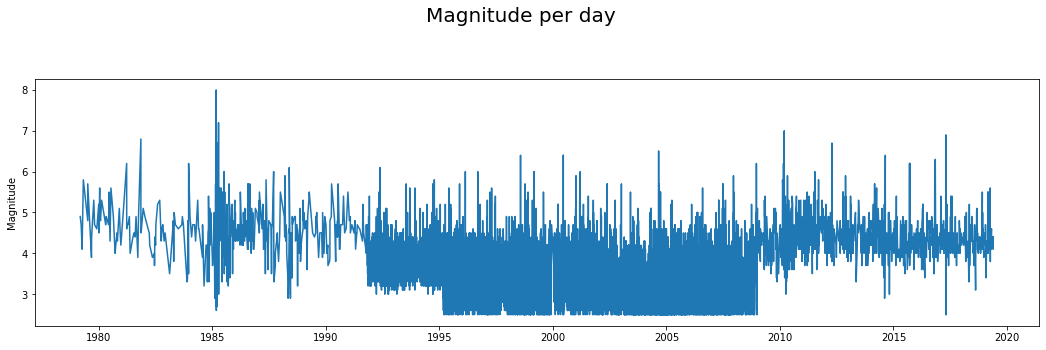

In [12]:
common.plot(sismos['date'], sismos['mag'], 'Magnitude', 'Magnitude per day')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12c593940>,
      dtype=object)

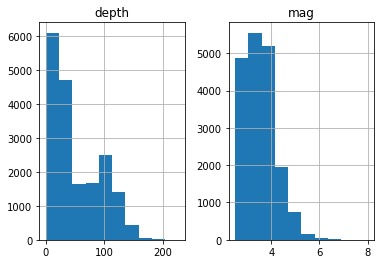

In [13]:
sismos.hist(['depth','mag'])

## 1.2. Time Series Data

1. For this analysis, we don't take into account 'magType' and we assume all the magnitudes measure the same beacuse:

    The Richter magnitude scale can only be used when seismographs are within 600 km of the earthquake. For greater distances, other magnitude scales have been defined. While not exactly the same as the original Richter magnitude, they give values that can range from less than 0.0 to over 9.0. For example, the surface wave magnitude, MS, is often used for large distant earthquakes. Most of these scales saturate at some magnitude and do not properly represent earthquake size for larger events. For example, the ML scale saturates over ML 6.0, while the MS scale can be used to about MS 8.0.

    The most modern scale is the moment magnitude scale MW, which can be used for a wide range of magnitudes and distances. This has been defined so that the numerical value is close to ML for earthquakes up to magnitude 6.0, and close to MS for magnitudes 6.0 to 8.0. The very largest earthquakes, such as experienced in Chile in 1960 or Alaska in 1964, can reach magnitudes larger than MW 9.0.

2. We discard information realted to the satation where data were collected.


In [14]:
read_data.read_data_time_series?

Signature: read_data.read_data_time_series(path)
Docstring:
Return required DataFrames for Time Series Analysis

:return: frequency_year, time_series_magnitude

frequency_year = frecuency of earthquakes per year and magnitude type where magtype is
                {low: mag in [0,4), medium: mag in [4,6), high: mag in [6,10)}
                        low --> you don't notice them
                        medium --> they are not scary
                        high --> the thing would get serious
                columns = ['year', 'magtype', 'magcount', 'magmax']

time_series_magnitude =  time series (frequency = month/yeam, data = maximum magnitude per period)
        
File:      ~/PycharmProjects/TFM_Earthquake/Earthquake_Prediction/models/read_data.py
Type:      function


In [15]:
frequency_year, mag_ym = read_data.read_data_time_series('./data/')

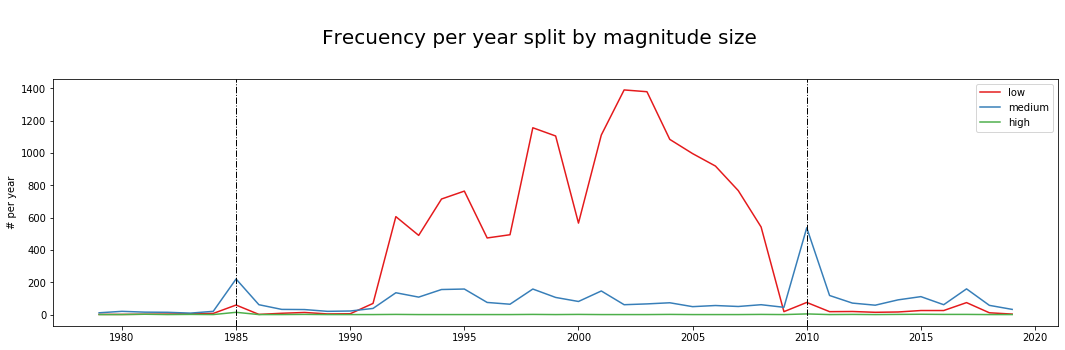

In [16]:
common.plot_time_series_with_big_earthquakes('\nFrecuency per year split by magnitude size', '# per year',
                                     'year',frequency_year,'magcount','magtype',sismos)

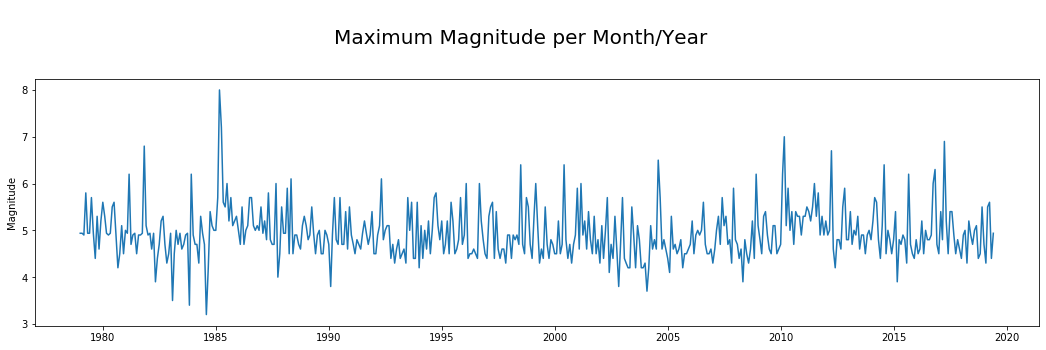

In [17]:
common.plot(mag_ym.index, mag_ym['mag'], 'Magnitude', '\nMaximum Magnitude per Month/Year')

## 1.3. Classification Data

In [18]:
read_data.read_data_classification?

Signature: read_data.read_data_classification(path)
Docstring:
 Read Temperature file and return a Dataframe and a Series

:return: features_classification and  label_classification

 features_classification = ['YM', '2', '3', '4', '5', '6', '7', '8', 'Tempt', 'TemptUncert']
                       where YM reference to month/year
                       and '2', '3', '4', '5', '6', '7', '8' contain the number of earthquakes of that magnitude

 label_classification = 1 if (next month has earthquakes > = 6) else is 0,
 so if a know the earthquakes magnitudes and temperatures of the current month, then I can predict next month
 
File:      ~/PycharmProjects/TFM_Earthquake/Earthquake_Prediction/models/read_data.py
Type:      function


In [19]:
features_classification, label_classification = read_data.read_data_classification('./data/')

In [20]:
features_classification.head(2)

,YM,2,3,4,5,6,7,8,Tempt,TemptUncert
0,1979-01-01,0,0,0,0,0,0,0,12.245,0.183
1,1979-02-01,0,0,0,0,0,0,0,11.158,0.313


In [21]:
label_classification[:3]

0    0
1    0
2    0
dtype: int64

In [22]:
title_figure = '\nFrecuency per month/year split by magnitude'
y_label = '# per month/year'
column_x='YM'
data_frame = features_classification
column_y = ''
column_lines = ['6','7','8']
data_frame_bar = sismos
big_earthquake = False

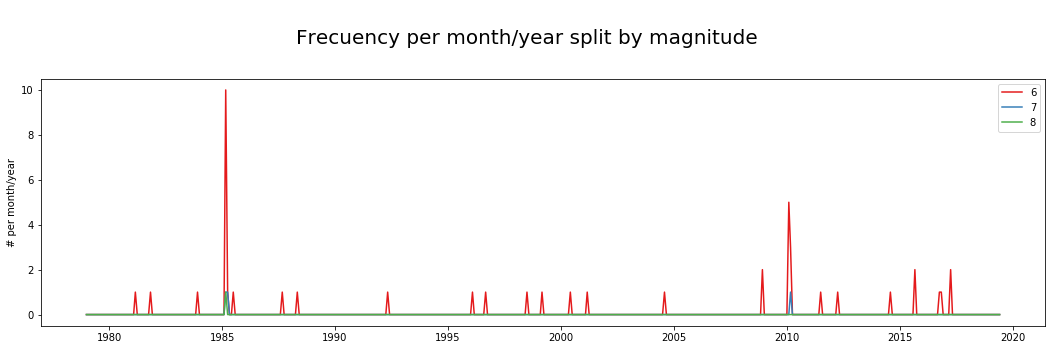

In [23]:
common.plot_regression_with_big_earthquake(title_figure,y_label,
                                           column_x,data_frame,
                                           column_y,column_lines,data_frame_bar,big_earthquake)

# 2. MODEL

## 2.1. Time Series
https://www.analyticsvidhya.com/blog/2018/08/auto-arima-time-series-modeling-python-r/

Time Series is a series of data points measured at a constant interval which may be hourly, daily, weekly and so on. What makes time series different is that each data point in the series is dependent on the previous data points.

__BOX-JENKINS METHODOLOGY - SUMMARY__
1.  Plot Series
    * If variance is not constant (multiplicative model) $\rightarrow$ take logarithm to make it additive
2.  Stationary 
    * Differentiate 
    * Decompose and take random part
3.  Check it is stationary with Augmented Dickey-Fuller test
4.  Plot ACF and PACF to obtain p, q in ARMA(p,q)
5.  Select the most adequate model
6.  Forecast

In [24]:
my_time_series = time_series.TimeSeries(frequency_year, mag_ym)

### 1. Plot Rolling Statistics

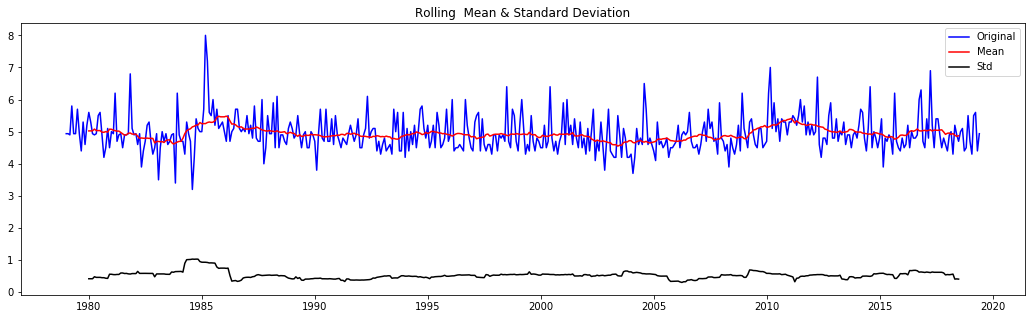

In [25]:
common.plot_rolling_stadistics(mag_ym)

Constant mean and standard variance, so Series is additive and stationary.

### 2. Stationary

How Does a Stationary Series look like?
* Constant Average
* Constant Variance
* Autocovariance does not depend on the time

How does a Non Stationary Series look like?
* Trend
* Seansonality

If it had not been stationary, we would have had to differentiate it as follows

```python
mag_diff = diff(mag_ym,k_diff=1)
```

Decompose time series

True

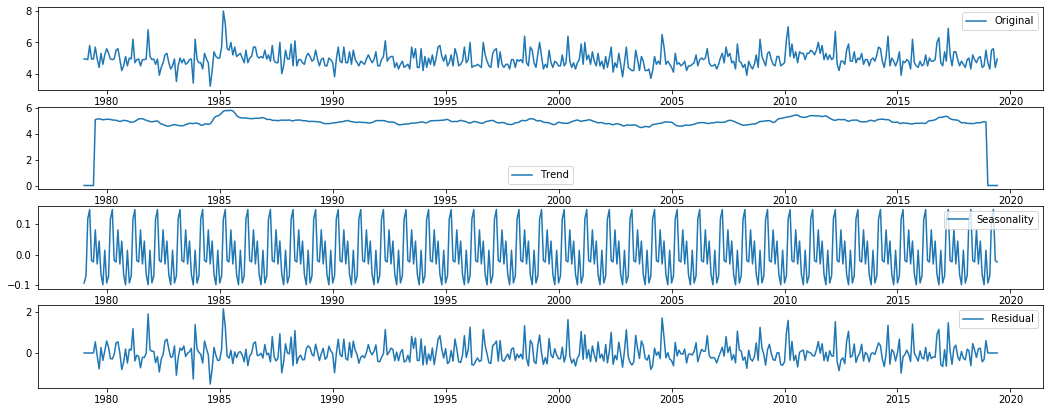

In [26]:
my_time_series.decomposition()

* There is no trend
* Seasonality per year
* Additive model

### 3. Dickey Fuller Test

`Null Hypothesis`: TS has a unit root and hence is non-stationary.
    
`Test Statistic`: The more negative, the more likely we are to reject the null hypothesis (we have a stationary dataset).

We reject the null (so it is stationary) if (p-value) is small

In [27]:
result_tst = my_time_series.dickey_fuller_test()
print(result_tst)

Dickey-Fuller Test: Magnitude per year 

ADF test statistic     -8.753158e+00
p-value                 2.800968e-14
# lags used             3.000000e+00
# observations          4.820000e+02
critical value (1%)    -3.443990e+00
critical value (5%)    -2.867555e+00
critical value (10%)   -2.569974e+00

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### 4. ACF / PACF
https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/

__ACF (AutoCorrelation Function)__: 
It measures the relation between Xt and Xt+n, including Xj for j=t+1,... t+n

For __MA(q)__: Xt = εt + b1εt-1 + b2εt-2 + ... + bqεt-q , __ACF(k)__ will be 0, k>q  $\rightarrow$  see at what lag it goes down to 0

For our dataset q could be 0 or 1

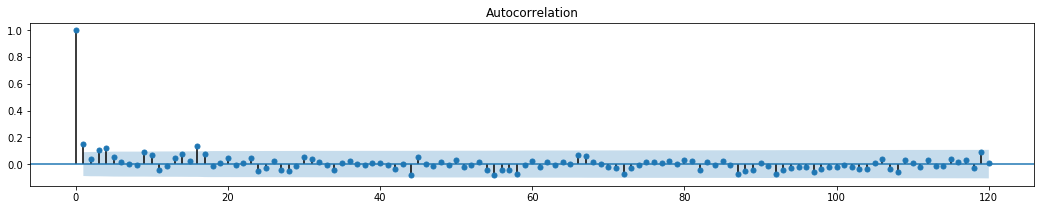

In [28]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(18,3))
    plot_acf(mag_ym, lags = 120)
    plt.show();

__PACF (Partial Autocorrelation Function)__: measures the direct relation between Xt and Xt+n, excluding Xj for j=t+1,..., t+n-1

For __AR(p)__: Xt = a1Xt-1 + a2Xt-2 + ... + apXt-p + εt. __PACF(k)__ will be high for k=1,..., p, but will be 0 afterwards (by definition) $\rightarrow$ see at what lag it goes down to 0

For our dataset q could be 1 or 16

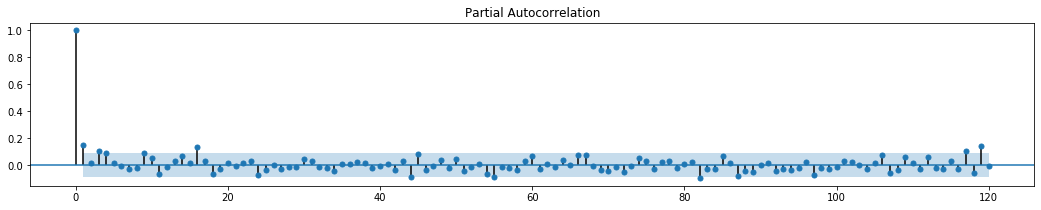

In [29]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(18,3))
    plot_pacf(mag_ym, lags=120)
    plt.show();

### 5. Most Adequate Model

In [30]:
try:
    from pmdarima import auto_arima
except:
    ! pip install pmdarima
    from pmdarima import auto_arima

__auto_arima__ returns best ARIMA model according to either AIC, AICc or BIC value. 

The function conducts a search over possible model within the order constraints provided.

In [31]:
from pmdarima import auto_arima
# Stationary Dataset
stepwise_fit = auto_arima(mag_ym,start_p=0,start_q=0,max_p=6,max_q=6,seasonal=False,trace=True)

Fit ARIMA: order=(0, 0, 0); AIC=806.941, BIC=815.314, Fit time=0.004 seconds
Fit ARIMA: order=(1, 0, 0); AIC=798.334, BIC=810.893, Fit time=0.024 seconds
Fit ARIMA: order=(0, 0, 1); AIC=798.693, BIC=811.252, Fit time=0.019 seconds
Fit ARIMA: order=(2, 0, 0); AIC=800.145, BIC=816.890, Fit time=0.027 seconds
Fit ARIMA: order=(1, 0, 1); AIC=795.757, BIC=812.502, Fit time=0.107 seconds
Fit ARIMA: order=(2, 0, 2); AIC=797.360, BIC=822.478, Fit time=0.217 seconds
Fit ARIMA: order=(2, 0, 1); AIC=796.430, BIC=817.361, Fit time=0.156 seconds
Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.580 seconds


In [32]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  486
Model:                     ARMA(1, 1)   Log Likelihood                -393.878
Method:                       css-mle   S.D. of innovations              0.544
Date:                Fri, 07 Jun 2019   AIC                            795.757
Time:                        17:44:51   BIC                            812.502
Sample:                             0   HQIC                           802.335
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9378      0.039    126.670      0.000       4.861       5.014
ar.L1.y        0.8321      0.131      6.339      0.000       0.575       1.089
ma.L1.y       -0.7337      0.163     -4.490      0.000      -1.054      -0.413
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2018           +0.0000j            1.2018            0.0000
MA.1            1.3630           +0.0000j            1.3630            0.0000
-----------------------------------------------------------------------------
"""

The best model is the one with smaller AIC, that is __ARMA(1, 1)__

__AIC (Akaike Information Criterion)__ manages a trade-off between the goodness of fit of the model and the complexity of the model. 

AIC does not provide a proof of a model (there is not a null hypothesis), so it can not say anything about the quality of the model in an absolute sense. If all the candidate models fit badly, AIC will not give any notice of it.

## 6. Forecast
https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [33]:
from statsmodels.tsa.arima_model import ARIMA

In [34]:
model = ARIMA(mag_ym, order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                    mag   No. Observations:                  486
Model:                     ARMA(1, 1)   Log Likelihood                -393.878
Method:                       css-mle   S.D. of innovations              0.544
Date:                Fri, 07 Jun 2019   AIC                            795.757
Time:                        17:44:51   BIC                            812.502
Sample:                    01-01-1979   HQIC                           802.335
                         - 06-01-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9378      0.039    126.670      0.000       4.861       5.014
ar.L1.mag      0.8321      0.131      6.339      0.000       0.575       1.089
ma.L1.mag     -0.7337      0.163     -4.490      0.0

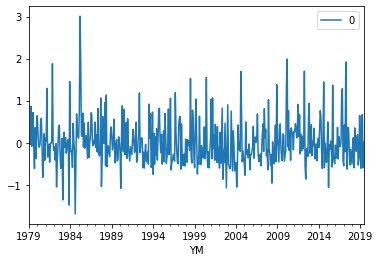

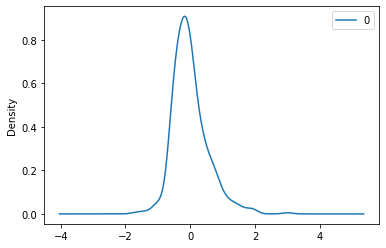

                0
count  486.000000
mean    -0.000351
std      0.544704
min     -1.694610
25%     -0.359543
50%     -0.093983
75%      0.246158
max      3.006948


In [35]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [36]:
forecast_period =  pd.date_range(start='1/1/2020', end='1/1/2021', freq='MS')

In [38]:
start_month = forecast_period[0]
end_month = forecast_period[2]
forecast = model_fit.predict(start=1, end=450)
forecast2 = model_fit.predict(start=486, end=510)

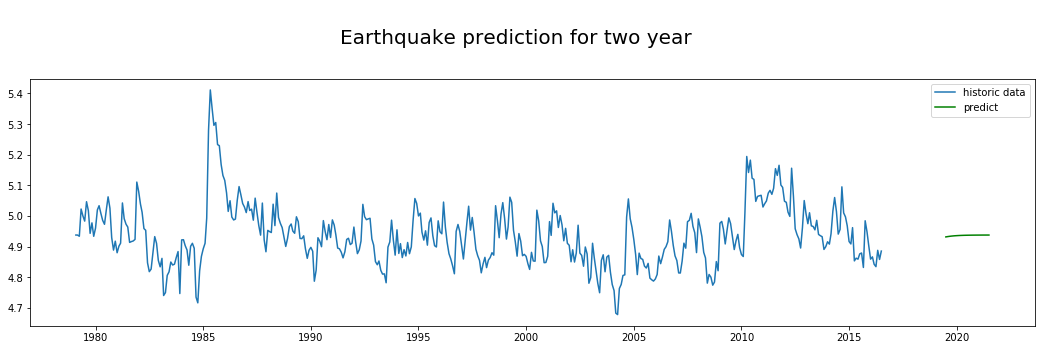

In [39]:
plt.figure(figsize=(18, 10))
plt.subplot(211)
plt.suptitle('\nEarthquake prediction for two year', fontsize=20)
plt.plot(forecast, label='historic data')
plt.plot(forecast2, color='green', label='predict')
plt.legend(loc='best')
plt.show;

As expected it is not a good prediction

## 2.2. Classification

In [40]:
my_models = supervised_models.Supervised(features_classification.drop('YM', axis=1), label_classification)

2019-06-07 17:45:16,128 [SUP] [INFO]  Initialized Supervised class. Data splited into Train, Test



In [41]:
my_models.evaluate_best_model?

Signature: my_models.evaluate_best_model(models)
Docstring:
Evaluate different models to choose the best one

:param models: should be Dict {ModelName: (Model, Parameter grid to be evaluated)}
:return: best model, evaluated with GridSearchCV
File:      ~/PycharmProjects/TFM_Earthquake/Earthquake_Prediction/models/supervised_models.py
Type:      method


In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [43]:
class_models = {'LogisticRegression':     (LogisticRegression(),     {}),
                        'KNeighborsClassifier':   (KNeighborsClassifier(),   {'n_neighbors': np.arange(2, 10)}),
                        'DecisionTreeClassifier': (DecisionTreeClassifier(), {'min_samples_leaf': np.arange(50, 300, 50),
                                                                              'max_depth': np.arange(2, 10)}),
                        'SVC':                    (SVC(kernel="linear"),     {'C': np.arange(1, 3)}),
                        'RandomForestClassifier': (RandomForestClassifier(), {'n_estimators': np.arange(1, 3),
                                                                              'max_depth': np.arange(1, 3),
                                                                              'min_samples_leaf': np.arange(1, 3)})}

In [44]:
data_best_model = my_models.evaluate_best_model(class_models)

2019-06-07 17:45:22,224 [SUP] [INFO]  LogisticRegression, Parameters Grid Search: {}
2019-06-07 17:45:22,225 [SUP] [INFO]  Init Cross validation
2019-06-07 17:45:22,250 [SUP] [INFO]  Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), Best Metric accuracy: [0.94897959 0.94845361 0.94845361 0.86597938 0.94845361]

2019-06-07 17:45:22,251 [SUP] [INFO]  KNeighborsClassifier, Parameters Grid Search: {'n_neighbors': array([2, 3, 4, 5, 6, 7, 8, 9])}
2019-06-07 17:45:22,891 [SUP] [INFO]  Output: Score 0.9465020576131687 Parameter dict_values([4]) 

2019-06-07 17:45:22,892 [SUP] [INFO]  DecisionTreeClassifier, Parameters Grid Search: {'min_samples_leaf': array([ 50, 100, 150, 200, 250]), 'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9])}
2019-06-07 17:45:23,467 [SUP] [INFO]  Output

In [45]:
best_model = data_best_model[1][1]

In [46]:
y_hat = best_model.predict(my_models.X_test)

It seems to be good but let take a look at ROC curve

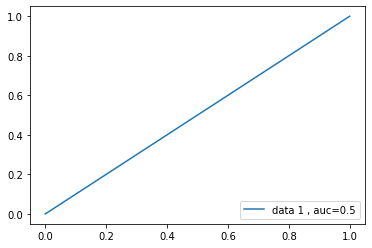

In [47]:
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(my_models.y_test, y_hat)
auc = metrics.roc_auc_score(my_models.y_test, y_hat)
plt.plot(fpr,tpr,label='data 1 , auc='+str(auc))
plt.legend(loc=4)
plt.show()

Very bad model!!
Model predicts that never will be a earthquake.... hopefully! 
As I told before, objective was to learn not to predict earthquake.

SHAP: 
* http://www.f1-predictor.com/model-interpretability-with-shap/

* https://github.com/slundberg/shap